# Bike Demand

<img src="files/data/bikes.png">

Bike sharing systems are a means of renting bicycles where the process of obtaining membership, rental, and bike return is automated via a network of kiosk locations throughout a city. Using these systems, people are able rent a bike from one location and return it to a different place on an as-needed basis. Currently, there are over 500 bike-sharing programs around the world.

The data generated by these systems makes them attractive for researchers because the duration of travel, departure location, arrival location, and time elapsed is explicitly recorded. Bike sharing systems therefore function as a sensor network, which can be used for studying mobility in a city. In this competition, participants are asked to combine historical usage patterns with weather data in order to forecast bike rental demand in the Capital Bikeshare program in Washington, D.C.

In [123]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#%pylab inline

from datetime import datetime, date, time

from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings('ignore')

In [124]:
df = pd.read_csv('./data/train.csv', parse_dates={'datetime'}, index_col='datetime')
df['month'] = df.index.month
df['weekday'] = df.index.weekday
df['hour'] = df.index.hour

df.head(5)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,month,weekday,hour
datetime,,,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0,3,13,16,1,5,0
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0,8,32,40,1,5,1
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0,5,27,32,1,5,2
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0,3,10,13,1,5,3
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0,0,1,1,1,5,4


### Exporing Dates

We first re-sample and plot hourly, weekly and monthly trends

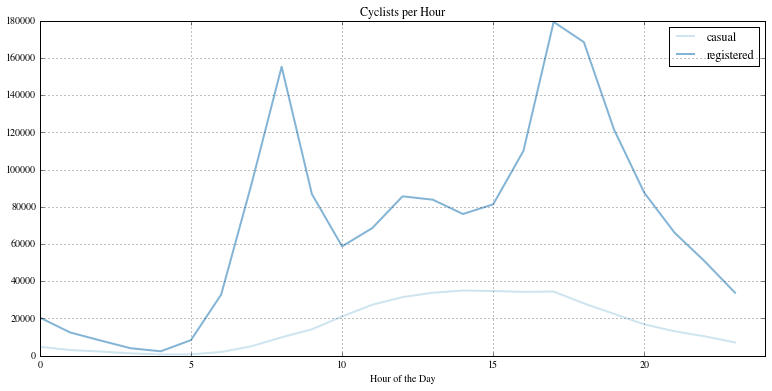

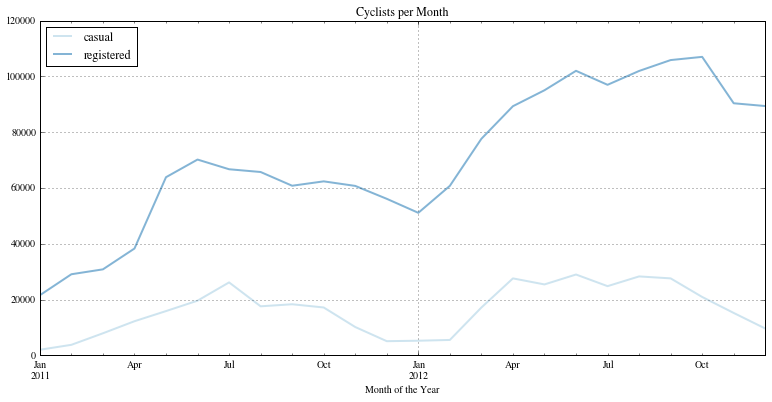

In [78]:
fig = plt.figure(figsize(13,6), dpi=1600);
a_bar = 0.55

df[['casual', 'registered']].groupby(df.index.hour).sum().plot(alpha = a_bar);plt.xlabel("Hour of the Day");title('Cyclists per Hour');xlim(0, 24);
df[['casual', 'registered']].resample('m', 'sum').plot(alpha = a_bar);plt.xlabel("Month of the Year");title('Cyclists per Month');
#df[['casual', 'registered']].resample('w', 'sum').plot(alpha = a_bar);plt.xlabel("Week of the Year");title('Cyclists per Week');

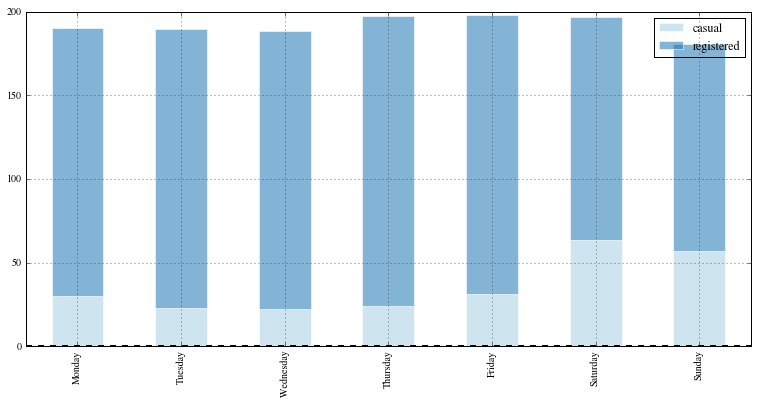

In [79]:
# Add the weekday column
week_day = df[['casual', 'registered']]
week_day['weekday'] = week_day.index.weekday

# Add up the number of cyclists by weekday, and plot!
weekday_counts = week_day.groupby('weekday').aggregate(np.average)
weekday_counts.index = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_counts.plot(kind='bar', stacked=True, alpha=a_bar);

First create a new column - Weekday(0-6) from the index. We then group by hour and weekday and remove the index. We then pivot that dataframe on the weekday column and plot using week day names instead of the 0-6 values.

We observe(as expected) that during the weekday, we have peaks around 8am and 6pm whereas the weekend experiences its busiest periods around lunch time:

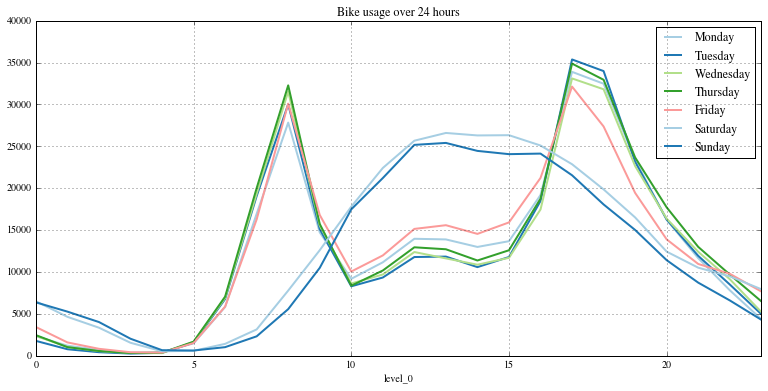

In [80]:
df['weekday'] = df.index.weekday
hour_week_group = df[['count']].groupby([df.index.hour, df.weekday]).sum().reset_index()
hourly_week_count = hour_week_group.pivot(index='level_0', columns='weekday', values='count')
hourly_week_count.columns = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
hourly_week_count.plot(); title('Bike usage over 24 hours');

### Heat Map

Just bloody beautiful!!

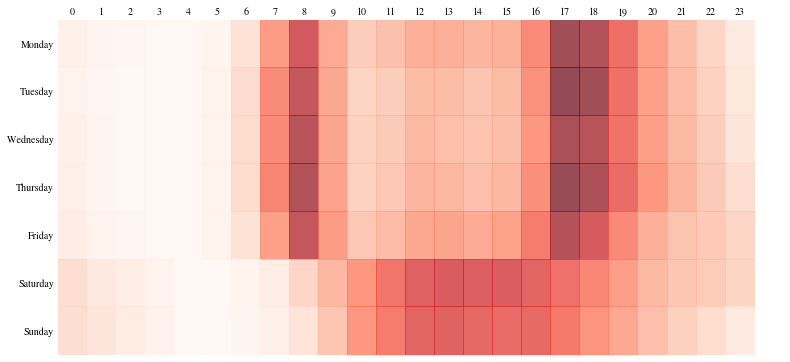

In [81]:
# Re-pivot table for heatmap
week_hour_group = df[['count']].groupby([df.index.hour, df.weekday]).sum().reset_index()
week_hour_count = hour_week_group.pivot(index='weekday', columns='level_0', values='count')

fig, ax = plt.subplots()
heatmap = ax.pcolor(week_hour_count, cmap=plt.cm.Reds, alpha=0.7)
nba_norm = (week_hour_count - week_hour_count.mean()) / (week_hour_count.max() - week_hour_count.min())
nba_sort = nba_norm.sort(ascending=True)

#fig = plt.figure(figsize(13,6), dpi=1600)
fig = plt.gcf()

#fig.set_size_inches(8,11)

# turn off the frame
ax.set_frame_on(False)

# put the major ticks at the middle of each cell
ax.set_yticks(np.arange(nba_sort.shape[0])+0.5, minor=False)
ax.set_xticks(np.arange(nba_sort.shape[1])+0.5, minor=False)

# want a more natural, table-like display
ax.invert_yaxis()
ax.xaxis.tick_top()

# labels for the y-axis
labels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# note I could have used nba_sort.columns but made "labels" instead
ax.set_xticklabels(nba_sort.columns, minor=False) 
ax.set_yticklabels(labels, minor=False)

# rotate the hour ticks 0/(90deg)
plt.xticks(rotation=0)
ax.grid(False)

# Turn off all the ticks
ax = plt.gca()

for t in ax.xaxis.get_major_ticks(): 
    t.tick1On = False 
    t.tick2On = False 
for t in ax.yaxis.get_major_ticks(): 
    t.tick1On = False 
    t.tick2On = False  

### Temperature Analysis

I'm struggling to understand what the difference between temp and atemp is - I'm going to create a new column temp_diff being just the difference between the two columns. We can also scatterplot to see if there's a correlation:

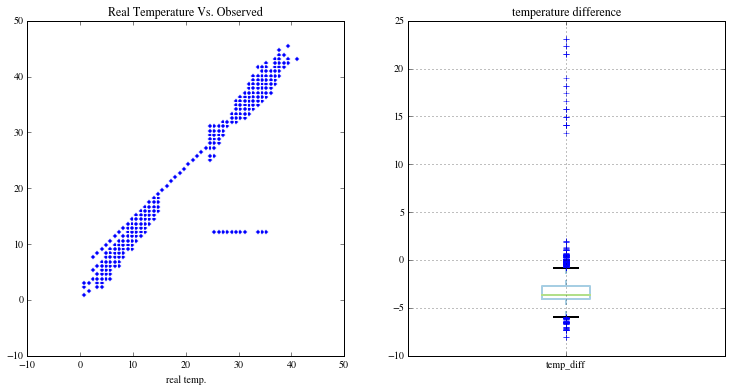

In [82]:
df['temp_diff'] = df['temp'] - df['atemp']

fig = plt.figure(figsize=(12.5,6))

fig.add_subplot(121)
plt.scatter(df.temp, df.atemp);plt.xlabel('real temp.');title('Real Temperature Vs. Observed')

fig.add_subplot(122)
df.boxplot(column='temp_diff');plt.title('temperature difference');print('\n');

We observe two situations here:

1. There are some extreme outliers for real temperatures. Based on the scatterplot, there may have been some misreadings in the sensor.

2. The real temperate is generally lower than what people think it is...

#### Correlation of Temperature and Usage

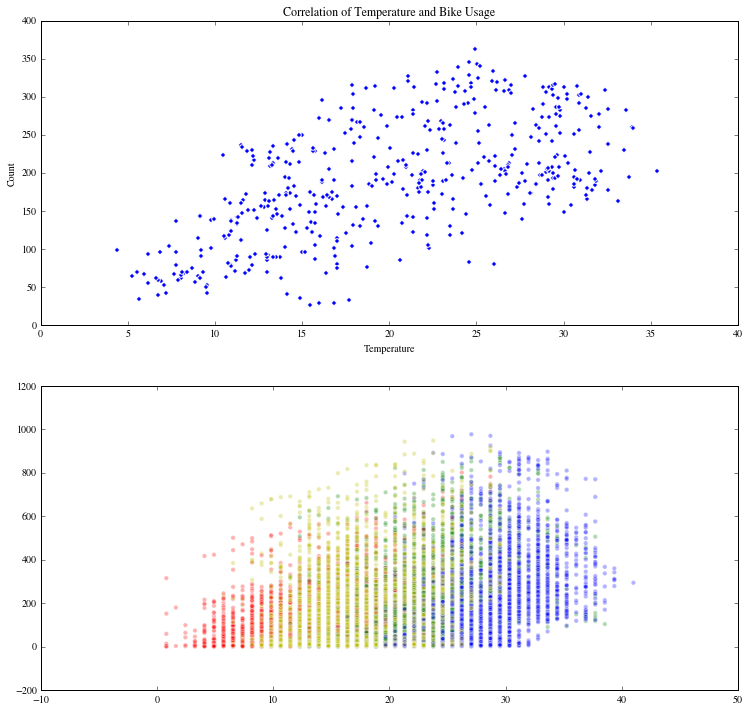

In [83]:
fig = plt.figure(figsize=(12.5,12))

plt.subplot2grid((2,1),(0,0))
daily_grouped = df[['temp', 'count']].groupby(df.index.date).mean() # group at daily level and take mean temp
plt.scatter(daily_grouped['temp'], daily_grouped['count'])
plt.title('Correlation of Temperature and Bike Usage');plt.xlabel('Temperature');plt.ylabel('Count');

plt.subplot2grid((2,1),(1,0))
colors = np.select([df.season == 1, df.season == 2, df.season == 3, df.season == 4], ['r','g', 'b', 'y'])
plt.scatter(df['temp'], df['count'], c=colors, alpha=0.3);

### Scatter Plot Matrix

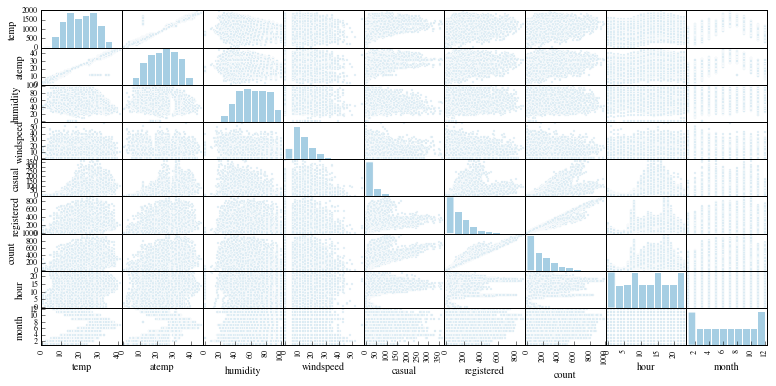

In [84]:
sp_data = df[['temp', 'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count', 'hour', 'month']]
pd.scatter_matrix(sp_data, alpha=0.7, diagonal='hist');

How does the season affect the usage of bike sharing?

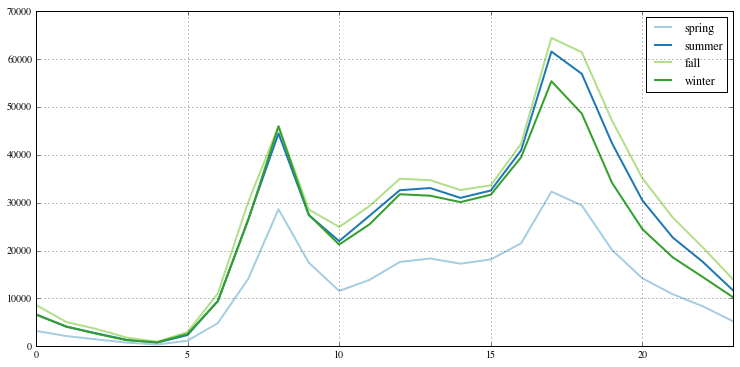

In [85]:
fig = plt.figure(figsize=(12.5,6))

spring = df['count'][df.season == 1]
summer = df['count'][df.season == 2]
fall = df['count'][df.season == 3]
winter = df['count'][df.season == 4]

spring.groupby(spring.index.hour).sum().plot(label='spring')
summer.groupby(summer.index.hour).sum().plot(label='summer')
fall.groupby(fall.index.hour).sum().plot(label='fall')
winter.groupby(winter.index.hour).sum().plot(label='winter');legend(loc='best');

### Feature Engineering

Of course there are going to be seasonal/weather effects in forecasting demand. I'm going to hypothesise that forecast will be at least partially due to changing daylight hours. We'll compute the number of hours of daylight and use this to de-trend the data:

In [86]:
def hours_daylight(date, axis=23.44, latitude=47.61):
    
    # Compute the hours in a day given a date
    diff = date - pd.datetime(2000, 12, 21)
    day = diff.total_seconds() / 24. / 3600
    day %= 365.25
    m = 1. - np.tan(np.radians(latitude)) * np.tan(np.radians(axis) * np.cos(day * np.pi / 182.625))
    m = max(0, min(m, 2))
    return 24. * np.degrees(np.arccos(1 - m)) / 180.
    
#hours_daylight(my_date, 23.44, 47.61)

## Modelling

Based on some of the observations above, we know that the behaviour of cyclists who use bikes casually vs. those who are registered is different. Therefore, we're going to build separate models, one for each of the 'casual' and 'registered' users. 

In [95]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_validation import train_test_split
from sklearn.metrics import make_scorer
from sklearn.grid_search import GridSearchCV


def rmsele(actual, pred):
    """
    Given a column of predictions and a column of actuals, calculate the RMSELE
    """
    squared_errors = (np.log(pred + 1) - np.log(actual + 1)) ** 2
    mean_squared = np.sum(squared_errors) / len(squared_errors)
    return np.sqrt(mean_squared)

In [96]:
df1 = df.drop(['count', 'registered', 'casual'], 1)
df1.reset_index(inplace=True)
df1 = df1.drop('datetime', 1)

X = df1
y = df['count']
features = X.columns

# Split the data into test and training groups
X_train, X_test, y_train, y_test = train_test_split(X, y)

### Grid Search

Now we can perform grid search in order to optimise the model parameters

In [99]:
rmsele_scorer = make_scorer(rmsele, greater_is_better=False)

# Optimisation of parameters
parameter_space = [{'max_features': ['sqrt', 'log2', 'auto'], 'max_depth':[5,8,12], 'min_samples_leaf':[2,5,10]}]
rf = GridSearchCV(RandomForestRegressor(n_jobs=1, n_estimators=1000),parameter_space, cv=3, verbose=2, 
                  scoring=rmsele_scorer).fit(X_train, y_train)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV] max_features=sqrt, max_depth=5, min_samples_leaf=2 ..............
[CV] ..... max_features=sqrt, max_depth=5, min_samples_leaf=2 -   2.6s
[CV] max_features=sqrt, max_depth=5, min_samples_leaf=2 ..............
[CV] ..... max_features=sqrt, max_depth=5, min_samples_leaf=2 -   2.8s
[CV] max_features=sqrt, max_depth=5, min_samples_leaf=2 ..............
[CV] ..... max_features=sqrt, max_depth=5, min_samples_leaf=2 -   2.6s
[CV] max_features=sqrt, max_depth=5, min_samples_leaf=5 ..............
[CV] ..... max_features=sqrt, max_depth=5, min_samples_leaf=5 -   2.6s
[CV] max_features=sqrt, max_depth=5, min_samples_leaf=5 ..............
[CV] ..... max_features=sqrt, max_depth=5, min_samples_leaf=5 -   2.5s
[CV] max_features=sqrt, max_depth=5, min_samples_leaf=5 ..............
[CV] ..... max_features=sqrt, max_depth=5, min_samples_leaf=5 -   2.5s
[CV] max_features=sqrt, max_depth=5, min_samples_leaf=10 .............
[CV] .... max_fe

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    2.6s
[Parallel(n_jobs=1)]: Done  41 jobs       | elapsed:  2.7min



[CV] max_features=log2, max_depth=8, min_samples_leaf=5 ..............
[CV] ..... max_features=log2, max_depth=8, min_samples_leaf=5 -   3.5s
[CV] max_features=log2, max_depth=8, min_samples_leaf=10 .............
[CV] .... max_features=log2, max_depth=8, min_samples_leaf=10 -   3.4s
[CV] max_features=log2, max_depth=8, min_samples_leaf=10 .............
[CV] .... max_features=log2, max_depth=8, min_samples_leaf=10 -   3.4s
[CV] max_features=log2, max_depth=8, min_samples_leaf=10 .............
[CV] .... max_features=log2, max_depth=8, min_samples_leaf=10 -   3.4s
[CV] max_features=auto, max_depth=8, min_samples_leaf=2 ..............
[CV] ..... max_features=auto, max_depth=8, min_samples_leaf=2 -  10.8s
[CV] max_features=auto, max_depth=8, min_samples_leaf=2 ..............
[CV] ..... max_features=auto, max_depth=8, min_samples_leaf=2 -  10.8s
[CV] max_features=auto, max_depth=8, min_samples_leaf=2 ..............
[CV] ..... max_features=auto, max_depth=8, min_samples_leaf=2 -  11.0s
[CV] 

[Parallel(n_jobs=1)]: Done  81 out of  81 | elapsed:  7.9min finished


In [100]:
print rf.best_estimator_

RandomForestRegressor(bootstrap=True, compute_importances=None,
           criterion='mse', max_depth=12, max_features='auto',
           max_leaf_nodes=None, min_density=None, min_samples_leaf=2,
           min_samples_split=2, n_estimators=1000, n_jobs=1,
           oob_score=False, random_state=None, verbose=0)


Now re-run the model with the optimal parameters on the entire training set

In [101]:
rf_opt = RandomForestRegressor(n_jobs=1, n_estimators=1000, oob_score=False, random_state=None,
                               min_samples_leaf=2, max_features='auto', min_samples_split=2)
rf_opt.fit(X, y)

RandomForestRegressor(bootstrap=True, compute_importances=None,
           criterion='mse', max_depth=None, max_features='auto',
           max_leaf_nodes=None, min_density=None, min_samples_leaf=2,
           min_samples_split=2, n_estimators=1000, n_jobs=1,
           oob_score=False, random_state=None, verbose=0)

In [108]:
preds = rf_opt.predict(X_test)

### Model Evaluation

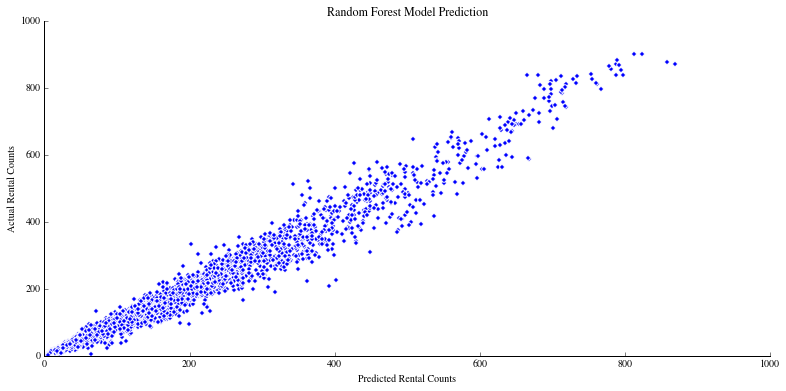

In [110]:
plt.scatter(preds, y_test)
plt.title("Random Forest Model Prediction")
plt.ylabel("Actual Rental Counts")
plt.xlabel("Predicted Rental Counts")
plt.xlim(0, 1000)
plt.ylim(0, 1000)
remove_border()

The above plot shows that there is a high correlation between actual/predicted rental counts

In [113]:
#Root Mean Squared Logarithmic Error (RMSLE)
print "Root Mean Squared Logarithmic Error Train: ", rmsele(rf_opt.predict(X_train), y_train)
print "Root Mean Squared Logarithmic Error Test: ", rmsele(rf_opt.predict(X_test), y_test)
print "Training accuracy: %0.2f%%" % (100*rf_opt.score(X_train, y_train))
print "Test accuracy: %0.2f%%" % (100*rf_opt.score(X_test, y_test)) + "\n"

 Root Mean Squared Logarithmic Error Train:  0.228124597062
Root Mean Squared Logarithmic Error Test:  0.220689087012
Training accuracy: 96.81%
Test accuracy: 96.85%



This is a suspiciously high accuracy rate.... Before trying to determine whether the model is over-fitting, let's look at the predictive power of each of the variables

In [118]:
df1.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,month,weekday,hour,temp_diff
0,1,0,0,1,9.84,14.395,81,0,1,5,0,-4.555
1,1,0,0,1,9.02,13.635,80,0,1,5,1,-4.615
2,1,0,0,1,9.02,13.635,80,0,1,5,2,-4.615
3,1,0,0,1,9.84,14.395,75,0,1,5,3,-4.555
4,1,0,0,1,9.84,14.395,75,0,1,5,4,-4.555


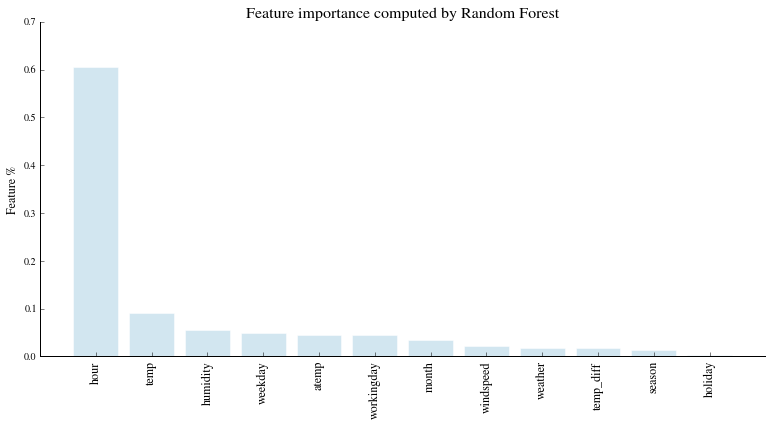

In [122]:
numfeat = len(features)
indices = np.argsort(rf_opt.feature_importances_)[::-1][:numfeat]

plt.bar(xrange(numfeat), rf_opt.feature_importances_[indices], align='center', alpha=.5)
plt.xticks(xrange(numfeat), features[indices], rotation='vertical', fontsize=12)
plt.xlim([-1, numfeat])
plt.ylabel('Feature %', fontsize=12)
plt.title('Feature importance computed by Random Forest', fontsize=16)
remove_border()

#print zip(features, rf_opt.feature_importances_)

In [34]:
from IPython.core.display import HTML

def css_styling():
    styles = open('custom.css', 'r').read()
    return HTML(styles)
css_styling()

This is code to improve the look and feel of plots using matplotlib

In [38]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import brewer2mpl
from matplotlib import rcParams

#colorbrewer2 Dark2 qualitative color table
dark2_cmap = brewer2mpl.get_map('Paired', 'Qualitative', 5)
dark2_colors = dark2_cmap.mpl_colors

rcParams['figure.figsize'] = (10, 6)
rcParams['figure.dpi'] = 150
rcParams['axes.color_cycle'] = dark2_colors
rcParams['lines.linewidth'] = 2
rcParams['axes.facecolor'] = 'white'
rcParams['font.size'] = 10
rcParams['patch.edgecolor'] = 'white'
rcParams['patch.facecolor'] = dark2_colors[0]
rcParams['font.family'] = 'StixGeneral'


def remove_border(axes=None, top=False, right=False, left=True, bottom=True):
    """
    Minimize chartjunk by stripping out unnecesasry plot borders and axis ticks
    
    The top/right/left/bottom keywords toggle whether the corresponding plot border is drawn
    """
    ax = axes or plt.gca()
    ax.spines['top'].set_visible(top)
    ax.spines['right'].set_visible(right)
    ax.spines['left'].set_visible(left)
    ax.spines['bottom'].set_visible(bottom)
    
    #turn off all ticks
    ax.yaxis.set_ticks_position('none')
    ax.xaxis.set_ticks_position('none')
    
    #now re-enable visibles
    if top:
        ax.xaxis.tick_top()
    if bottom:
        ax.xaxis.tick_bottom()
    if left:
        ax.yaxis.tick_left()
    if right:
        ax.yaxis.tick_right()